# Homework 3
## Andrey Novichkov 

**Goal:** Analyze the titanic dataset using pyspark

In [1]:
# Imports
from pyspark import SparkContext
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Start Spark Context and Spark Session

In [2]:
sc = SparkContext()
ss = SparkSession \
   .builder \
   .appName("Python Spark Titanic Dataset Analysis") \
   .config("spark.some.config.option", "some-value") \
   .getOrCreate()

### Turn input file into spark dataframe

In [3]:
filepath = "titanic.csv"
df = ss.read.csv(filepath, header=True, inferSchema=True)

In [4]:
df.show(2)

+-----------+--------+------+--------------------+------+----+-----+-----+---------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+---------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0| PC 17599|71.2833|  C85|       C|
+-----------+--------+------+--------------------+------+----+-----+-----+---------+-------+-----+--------+
only showing top 2 rows



### Do some general analysis

In [7]:
# Get number of passengers
print(f"Number of passengers in dataset: {df.count()}")

Number of passengers in dataset: 891


In [16]:
# Get number of survived/died
survived = df.filter(df.Survived == 1)
died = df.filter(df.Survived == 0)

print("Survival Statistics:")
print(f"Survived -> {survived.count()}")
print(f"Died -> {died.count()}")
print(f"% survived -> {round(survived.count()/df.count(), 2)}%")
print(f"% died -> {round(died.count()/df.count(), 2)}%")

Survival Statistics:
Survived -> 342
Died -> 549
% survived -> 0.38%
% died -> 0.62%


In [29]:
# Get stats about age of passengers
from pyspark.sql.functions import mean, min, max

print("Age statistics for all pasengers:")
df.select([mean('Age'), min('Age'), max('Age')]).show()

print("Age statistics for pasengers who survived:")
survived.select([mean('Age'), min('Age'), max('Age')]).show()

print("Age statistics for pasengers who died:")
died.select([mean('Age'), min('Age'), max('Age')]).show()

Age statistics for all pasengers:
+-----------------+--------+--------+
|         avg(Age)|min(Age)|max(Age)|
+-----------------+--------+--------+
|29.69911764705882|    0.42|    80.0|
+-----------------+--------+--------+

Age statistics for pasengers who survived:
+------------------+--------+--------+
|          avg(Age)|min(Age)|max(Age)|
+------------------+--------+--------+
|28.343689655172415|    0.42|    80.0|
+------------------+--------+--------+

Age statistics for pasengers who died:
+-----------------+--------+--------+
|         avg(Age)|min(Age)|max(Age)|
+-----------------+--------+--------+
|30.62617924528302|     1.0|    74.0|
+-----------------+--------+--------+



In [33]:
# Sex statistics of people who survived
survived_male = survived.filter(survived.Sex == "male")
survived_female = survived.filter(survived.Sex == "female")

print(f"Total Survived: {survived.count()}")
print(f"# Male: {survived_male.count()} -> {round(survived_male.count()/survived.count(), 2)}%")
print(f"# Female: {survived_female.count()} -> {round(survived_female.count()/survived.count(), 2)}%")

Total Survived: 342
# Male: 109 -> 0.32%
# Female: 233 -> 0.68%


In [34]:
# Sex statistics of people who survived
died_male = died.filter(died.Sex == "male")
died_female = died.filter(died.Sex == "female")

print(f"Total Died: {died.count()}")
print(f"# Male: {died_male.count()} -> {round(died_male.count()/died.count(), 2)}%")
print(f"# Female: {died_female.count()} -> {round(died_female.count()/died.count(), 2)}%")

Total Died: 549
# Male: 468 -> 0.85%
# Female: 81 -> 0.15%


### Some GroupBy Operations

In [58]:
class_group = df.groupBy(df.Pclass)
print("Count by passenger class:")
class_group.count().show()

print("Average fare per class:")
class_group.mean("Fare").show()

Count by passenger class:
+------+-----+
|Pclass|count|
+------+-----+
|     1|  216|
|     3|  491|
|     2|  184|
+------+-----+

Average fare per class:
+------+------------------+
|Pclass|         avg(Fare)|
+------+------------------+
|     1| 84.15468749999992|
|     3|13.675550101832997|
|     2| 20.66218315217391|
+------+------------------+



In [55]:
class_surv_group = df.groupBy(df.Survived, df.Pclass)
print()
class_surv_group.count().show()

+--------+------+-----+
|Survived|Pclass|count|
+--------+------+-----+
|       1|     2|   87|
|       1|     1|  136|
|       1|     3|  119|
|       0|     1|   80|
|       0|     2|   97|
|       0|     3|  372|
+--------+------+-----+



### Let's draw some visuals to better represent the data

In [35]:
pandas_df = df.toPandas()
pandas_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


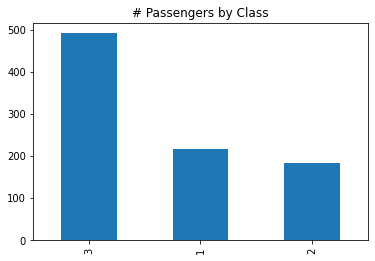

In [42]:
_= pandas_df['Pclass'].value_counts().plot(kind='bar', title="# Passengers by Class")

**Plotting is not supported inside of pyspark (YET!), so to plot we have to load the data from the spark context into our local python environment. This means that we need to have enough memory to store that data that is going to come from the spark context. To achieve this, we should sample the data. In this case, the titanic dataset is tiny, so we can easily add it into our local env. After we do that, we can load it into a pandas df and plot from there, like demonstrated above**